# In the previous tutorial we learnt how to use your ipython notebook for data (text to be precise) analysis. Here we would learn how to do spam classification based on Naive Bayes.

In [45]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import os
from os.path import join
import datetime as dt
from scipy.stats.stats import pearsonr
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.cross_validation import StratifiedKFold
import itertools

Import the downloaded data first

In [4]:
path = os.getcwd()
df_message = pd.read_csv(join(path,'smsspamcollection/SMSSpamCollection'),sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])

Previously we visualized messages and explored some statistics. Now we would learn how to create features from them. The essential steps include Doing that requires essentially three steps, in the bag-of-words model: <br />
1) Count how many times does a word occur in each message. We call it term frequency, <br />
2) Weight the counts, so that most frequent tokens get lower weight. We call it inverse document frequency, <br />
3) Normalize the vectors to unit length.

In [5]:
def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    return [word.lemma for word in words]

In [6]:
BOW_transform = CountVectorizer(analyzer=split_into_lemmas).fit(df_message['message'])

In [7]:
print BOW_transform.transform([df_message['message'][2]])

  (0, 21)	2
  (0, 103)	1
  (0, 452)	1
  (0, 472)	1
  (0, 484)	1
  (0, 893)	1
  (0, 948)	1
  (0, 1272)	1
  (0, 1899)	1
  (0, 2266)	1
  (0, 2479)	1
  (0, 3046)	2
  (0, 3177)	2
  (0, 3287)	1
  (0, 3437)	1
  (0, 4183)	1
  (0, 5029)	1
  (0, 6297)	1
  (0, 6350)	1
  (0, 6408)	1
  (0, 7310)	1
  (0, 7533)	1
  (0, 7647)	1
  (0, 7801)	1
  (0, 7812)	3
  (0, 7996)	1
  (0, 8485)	1
  (0, 8525)	1


Each message is called a vector and its length is the total number of unique words in the entire dataset (corpus)

In [49]:
print 'length of the vector is:', BOW_transform.transform([df_message['message'][2]]).shape[1]

length of the vector is: 8874


Lets make a quick verification to check if this representation is correct or not. We see for the word corresponding to 7812 we have an occurance frequency of 3. We can verify that by eyeing the message itself

In [51]:
print BOW_transform.get_feature_names()[7812]

to


In [52]:
df_message['message'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

So, 'to' indeed occured thrice in the text !!

Now lets convert the entire corpus using this approach

In [8]:
BOW = BOW_transform.transform(df_message['message'])

In [56]:
print 'Shape of the large transformed matrix is:', BOW.shape, 'i.e', BOW.shape[0], 'rows that corresponds to the number of messages and', BOW.shape[1], 'columns for each of the message that corresponds to the total number of unique words in the dataset'

Shape of the large transformed matrix is: (5574, 8874) i.e 5574 rows that corresponds to the number of messages and 8874 columns for each of the message that corresponds to the total number of unique words in the dataset


We have finished counting, now as per our previously mentioned 3 steps we need to perform term weighting and normalization. We would do that using the TfidfTransformer of the Scikit-learn

In [9]:
tfidf_BOW = TfidfTransformer().fit(BOW)

How does the previous message look now after this conversion ?

In [65]:
print tfidf_BOW.transform(BOW[2])

  (0, 8525)	0.179632904113
  (0, 8485)	0.138190739033
  (0, 7996)	0.118168109475
  (0, 7812)	0.171012810274
  (0, 7801)	0.208159499981
  (0, 7647)	0.11289854213
  (0, 7533)	0.133691560916
  (0, 7310)	0.185427055493
  (0, 6408)	0.157631945365
  (0, 6350)	0.157631945365
  (0, 6297)	0.158384636518
  (0, 5029)	0.148370514297
  (0, 4183)	0.0764098797291
  (0, 3437)	0.109085811318
  (0, 3287)	0.173494826823
  (0, 3177)	0.442847223391
  (0, 3046)	0.339376234237
  (0, 2479)	0.19016122188
  (0, 2266)	0.185427055493
  (0, 1899)	0.119671386057
  (0, 1272)	0.159958817058
  (0, 948)	0.0643973850704
  (0, 893)	0.208159499981
  (0, 484)	0.213953651361
  (0, 472)	0.213953651361
  (0, 452)	0.0944406763398
  (0, 103)	0.221423611696
  (0, 21)	0.183683813193


Let us also check the inverse document frequency of a word, say 'to'

In [67]:
print 'inverse document frequnency of the word "to" is:', tfidf_BOW.idf_[BOW_transform.vocabulary_['to']]

inverse document frequnency of the word "to" is: 2.19534051378


Lets do the conversion of the entire 'bag of words' converted corpus

In [10]:
converted_messages = tfidf_BOW.transform(BOW)

In [75]:
t1 = dt.datetime.now()
spam_detector = MultinomialNB().fit(converted_messages, df_message['label'])
t2 = dt.datetime.now()
print 'total time taken in training:', (t2-t1)

 total time taken in training: 0:00:00.014785


Lets try to see how does it perform:

In [77]:
print 'predicted:', spam_detector.predict(tfidf_BOW.transform(BOW[2]))[0]
print 'expected:', df_message['label'][2]

 predicted: spam
expected: spam


Next try cross validation with this model as well as SVM and a Random Forest and compare the performance. We would only show how do achieve this with NaiveBayes. We use a StratifiedKfold which is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [51]:
target = np.array(df_message['label'].tolist())
features = converted_messages
skf = StratifiedKFold(target, n_folds=5)

In [52]:
true_ = []
pred_ = []
for train_index, test_index in skf:
    spam_detector = MultinomialNB().fit(converted_messages[train_index], target[train_index])
    predict = spam_detector.predict(converted_messages[test_index])
    true_.append(target[test_index])
    pred_.append(predict)
    

In [53]:
TrueLabel = list(itertools.chain(*true_))
PredictedLabel = list(itertools.chain(*pred_))

We would check some performance metrics like the confusion matrix, correlation, f1 score etc. 

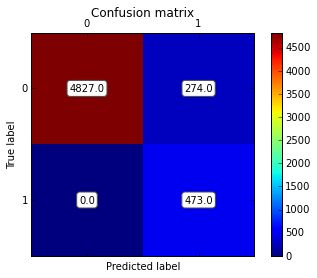

In [54]:
cm = confusion_matrix(PredictedLabel, TrueLabel)
fig, ax = plt.subplots()
im = ax.matshow(cm)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
plt.title('Confusion matrix')
fig.colorbar(im)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [55]:
TrueLabel = [1 if x=='spam' else 0 for x in TrueLabel]
PredictedLabel = [1 if x=='spam' else 0 for x in PredictedLabel]

In [60]:
print 'Correlation between the actual and prediction is:', pearsonr(TrueLabel, PredictedLabel)[0], 'with p-value',  ("%.2f" % pearsonr(TrueLabel, PredictedLabel)[1])

Correlation between the actual and prediction is: 0.77407181965 with p-value 0.00


In [41]:
target_names = ['Spam', 'ham']
print(classification_report(TrueLabel, PredictedLabel, target_names=target_names))

             precision    recall  f1-score   support

       Spam       0.95      1.00      0.97      4827
        ham       1.00      0.63      0.78       747

avg / total       0.95      0.95      0.95      5574



In [42]:
print 'Area under the curve (AUC) is:', roc_auc_score(TrueLabel, PredictedLabel)

Area under the curve (AUC) is: 0.816599732262


In [46]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(TrueLabel, PredictedLabel)
roc_auc = auc(false_positive_rate, true_positive_rate)

Lets also check the ROC plot

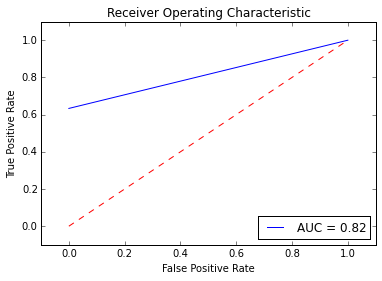

In [61]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()